
## Capstone Project Overview

The capstone project has three main tasks, each of which requires you to use skills you developed during the Nanodegree program. Once you complete all three tasks, please submit the project as a PDF.
Tips

- Splitting up the workflows makes the process more manageable.
- Map out your work: Before you dive into your analysis, think about the steps and plan ahead. This will reduce the amount of unnecessary work.
- Use visualizations: Include visualizations to help explain your decisions and communicate your findings. Remember what you learned about making them look great!
- Ask for help: Mentors and your fellow students can help you if you get stuck on something. When posting a question, make sure you include enough specificity so others can help.




## Task 1: Store Format for Existing Stores

Your company currently has 85 grocery stores and is planning to open 10 new stores at the beginning of the year. Currently, all stores use the same store format for selling their products. Up until now, the company has treated all stores similarly, shipping the same amount of product to each store. This is beginning to cause problems as stores are suffering from product surpluses in some product categories and shortages in others. You've been asked to provide analytical support to make decisions about store formats and inventory planning.


- Determine the optimal number of store formats based on sales data.
    - Sum sales data by StoreID and Year
    - Use percentage sales per category per store for clustering (category sales as a percentage of total store sales).
    - Use only 2015 sales data.
    - Use a K-means clustering model.
 - Segment the 85 current stores into the different store formats.
 - Use the StoreSalesData.csv and StoreInformation.csv files.

### Load the store dataset using Pandas

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns

from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
st_data = pd.read_csv('data/storesalesdata.csv')
st_info = pd.read_csv('data/storeinformation.csv')

In [3]:
st_data.head()

,Store,Day,Month,Year,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
0,S0001,1,3,2012,23401.06,5567.90,3930.28,5223.61,4542.28,238.58,2608.78,1651.77,4304.79
1,S0001,2,3,2012,32442.93,8009.52,4712.31,6174.72,9503.45,245.29,2692.72,2688.89,4467.51
2,S0001,3,3,2012,40433.61,9759.20,5969.03,8010.67,12793.92,282.12,3493.85,2929.85,5721.60
3,S0001,4,3,2012,57043.39,13966.26,9008.24,13142.55,16635.77,316.72,5618.55,4270.38,8313.11
4,S0001,5,3,2012,32894.86,7870.66,5448.35,5459.29,8358.96,198.00,3339.59,2061.21,5280.16


# Filter store sales data of year 2015

In [4]:
store_sales_2015 = st_data.query('Year == 2015').iloc[:, np.r_[0,  4:13]] 
# store sales columns
cols = store_sales_2015.iloc[:, 1:].columns


### Use percentage sales per category per store for clustering (category sales as a percentage of total store sales).

In [5]:
#  Aggregate the sum of each store
store_sales_2015_sum = store_sales_2015.groupby('Store')[cols].sum()

# calculate the total sum of each category per store
store_sales_2015_sum['Total Sales'] = store_sales_2015_sum.sum(axis=1)
# Calculate the percentage of each category per store
percentage_per_category_2015 = store_sales_2015_sum.div(store_sales_2015_sum['Total Sales'], axis=0).iloc[:,:-1]

percentage_per_category_2015

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
Store,,,,,,,,,
S0001,0.461347,0.103084,0.077199,0.107677,0.097171,0.006769,0.043550,0.035544,0.067658
S0002,0.457528,0.106388,0.078841,0.114903,0.101259,0.007438,0.039792,0.029702,0.064149
S0003,0.421349,0.102356,0.069027,0.114713,0.125399,0.009631,0.041761,0.036108,0.079655
S0004,0.454560,0.097111,0.080277,0.127728,0.100409,0.006120,0.041785,0.034469,0.057542
S0005,0.440169,0.106268,0.086339,0.101863,0.131112,0.008877,0.035389,0.022607,0.067376
...,...,...,...,...,...,...,...,...,...
S0081,0.423280,0.102089,0.086592,0.123493,0.116666,0.008475,0.038956,0.042944,0.057506
S0082,0.460995,0.100760,0.075290,0.113610,0.101490,0.005269,0.048267,0.035212,0.059107
S0083,0.447873,0.108865,0.083793,0.109469,0.117443,0.007097,0.031885,0.025206,0.068370


### Clustering Sales data using a K-means clustering model.

In [143]:
def optimalK(data, score_metric, kmax):
    scaled_data = MinMaxScaler().fit_transform(data)
    score_list = []
    for k in kmax:
        km = KMeans(n_clusters=k).fit(scaled_data)
        labels = km.labels_
        pred = km.fit_predict(scaled_data)
        score = score_metric(data, pred)
        score_list.append(score)
        
    return score_list

In [148]:
kmax = range(2, 11)
score1 = optimalK(percentage_per_category_2015, calinski_harabasz_score, kmax)
score2 = optimalK(percentage_per_category_2015, silhouette_score, kmax)
score3 = optimalK(percentage_per_category_2015, davies_bouldin_score, kmax)

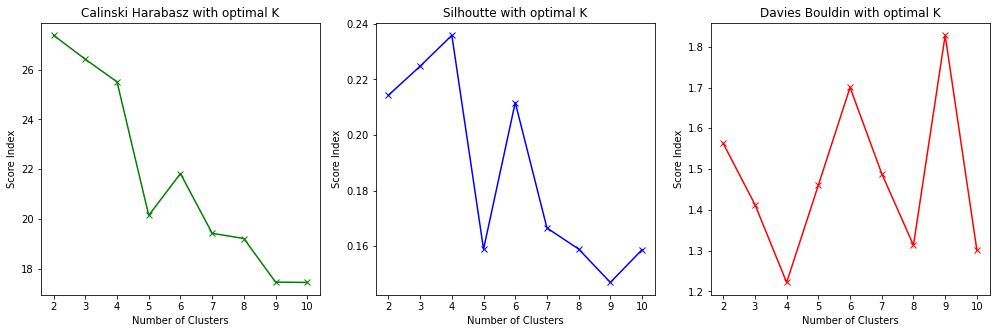

In [149]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
    
ax[0].plot(kmax, score1, 'bx-', color='green')
ax[1].plot(kmax, score2, 'bx-', color='blue')
ax[2].plot(kmax, score3, 'bx-', color='red')
for i in range(3):
    ax[i].set_xlabel('Number of Clusters')
    ax[i].set_ylabel('Score Index')

ax[0].set_title('Calinski Harabasz with optimal K')
ax[1].set_title('Silhoutte with optimal K')
ax[2].set_title('Davies Bouldin with optimal K')
plt.savefig("images/cluster_plot.png", bbox_inches='tight', dpi=300)
plt.show()

I have tested the clusters to find the optimal k value using three different methods. From the above plot, the score restuls are:-

##### Score Results #####
- Calinski Harabasz Score:-the higher the score is the better: 2 Cluster
- Silhoutte Score:- the higher the score is the better: 3 Cluster
- Davies Bouldin Score:- the lower the score is the better: 3 Cluster

Therefore, the optimal cluster number is 3.

### Segnment the store using the optimal cluster number

In [125]:
# Clusters - number of clusters = 3 
kmeans = KMeans(n_clusters=3)
# scale data
scaled_data = StandardScaler().fit_transform(percentage_per_category_2015)
kmeans_fitted = kmeans.fit(scaled_data)
# Add cluser label to data
#pred = kmeans.predict(scaled_data)
store_cluster_no = percentage_per_category_2015.assign(Segment = kmeans_fitted.labels_)
#store_cluster_no['Segment'].replace({0: "1", 1: "2", 2: "3"}, inplace=True)

# check numbers of stores in each Segment
print('Number of stores in each Cluster')
store_cluster_no.reset_index().groupby('Segment')['Store'].count().reset_index().rename(
    columns={'Store':'Size'})

Number of stores in each Cluster


,Segment,Size
0,0,23
1,1,29
2,2,33


# Comparison of Percentage Store Sales in each Cluster

In [97]:
# Filter store segment
store_segment = store_cluster_no.iloc[:,-1:]

In [120]:
# Scaled percentage data (within each product category) merged with Cluster number. 
pct_per_category_scaled = pd.DataFrame(StandardScaler().fit_transform(percentage_per_category_2015), 
                                          columns=percentage_per_category_2015.columns, 
                                          index = percentage_per_category_2015.index)

scaled_pct_cluster = pct_per_category_scaled.merge(store_segment, how = 'inner', 
                                left_on = pct_per_category_scaled.index,
                                 right_on = store_segment.index, right_index=True ).iloc[:, 1:]

In [121]:
store_cluster_grouped = scaled_pct_cluster.groupby('Segment').mean()
store_cluster_grouped

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
Segment,,,,,,,,,
0,0.169648,-0.715919,-0.429498,-0.050894,-0.531226,-0.279179,-0.183078,-0.840332,1.332182
1,0.578442,-0.175279,-0.051571,0.439251,-0.557843,-0.587300,0.645243,0.212032,-0.620086
2,-0.717496,0.689004,0.358039,-0.417302,0.952837,0.804372,-0.536132,0.377492,-0.305331


<AxesSubplot:>

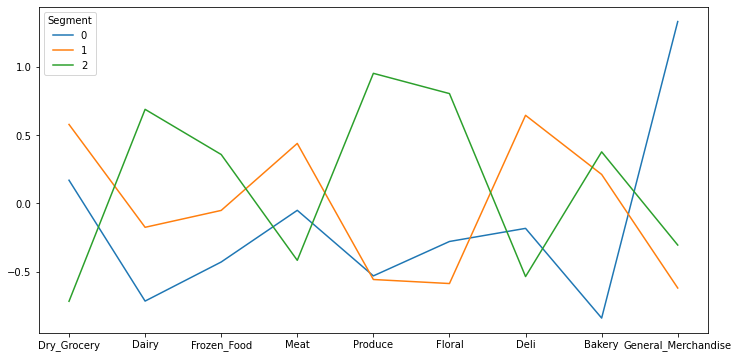

In [122]:
store_cluster_grouped.T.plot(kind='line')

In [156]:
# Merge the sales_per_2015 data with store information data using inner join
sales_per_2015 = store_cluster_no.reset_index()
merged_store_data = sales_per_2015.merge(st_info, how='inner', on='Store')

In [157]:
# save to csv and map the cluster on Tableau
merged_store_data.to_csv('data/merged_store_data.csv', index=False)

# Task 1: Submissing

Task 1 Submission

1. What is the optimal number of store formats? How did you arrive at that number?
2. How many stores fall into each store format?
3. Based on the results of the clustering model, what is one way that the clusters differ from one another?
4. Please provide a map created in Tableau that shows the location of the existing stores, uses color to show cluster, and size to show total sales. Make sure to include a legend! Feel free to simply copy and paste the map into the submission template.


# Task 2: Store Format for New Stores

The grocery store chain has 10 new stores opening up at the beginning of the year. The company wants to determine which store format each of the new stores should have. However, we don’t have sales data for these new stores yet, so we’ll have to determine the format using each of the new store’s demographic data.


# Task 2: Determine the Store Format for New Stores

You’ve been asked to:

- Develop a model that predicts which segment a store falls into based on the demographic and socioeconomic characteristics of the population that resides in the area around each new store.
- Use a 20% validation sample with Random Seed = 3 when creating samples with which to compare the accuracy of the models. Make sure to compare a decision tree, forest, and boosted model.
- Use the model to predict the best store format for each of the 10 new stores.
- Use the StoreDemographicData.csv file, which contains the information for the area around each store.
- Note: In a real world scenario, you could use PCA to reduce the number of predictor variables. However, there is no need to do so in this project. You can leave all predictor variables in the model.


## Load Store Demographic dataset

In [250]:
st_dm = pd.read_csv('data/storedemographicdata.csv')
st_cluster = pd.read_csv('data/merged_store_data.csv')
st_dm.head()

,Store,Age0to9,Age10to17,Age18to24,Age25to29,Age30to39,Age40to49,Age50to64,Age65Plus,EdLTHS,...,PopPacIsl,PopWhite,HVal0to100K,HVal100Kto200K,HVal200Kto300K,HVal300Kto400K,HVal400Kto500K,HVal500Kto750K,HVal750KPlus,PopDens
0,S0001,0.138163,0.111414,0.113228,0.081671,0.134924,0.128832,0.160429,0.131359,0.241935,...,0.002669,0.454295,0.073853,0.115967,0.223511,0.301880,0.180786,0.097168,0.006836,4260.943672
1,S0002,0.138954,0.112723,0.100572,0.074832,0.121080,0.146961,0.195456,0.109422,0.125224,...,0.002879,0.729696,0.124956,0.127915,0.206578,0.223808,0.174730,0.129133,0.012879,3061.060073
2,S0003,0.108582,0.091262,0.113486,0.111415,0.182909,0.144938,0.150248,0.097170,0.321860,...,0.000802,0.182080,0.024665,0.065257,0.114870,0.150106,0.155462,0.251445,0.238196,13740.923328
3,S0004,0.142758,0.102582,0.083941,0.062370,0.131661,0.134041,0.158762,0.183922,0.198362,...,0.001904,0.516900,0.175374,0.112920,0.095161,0.247891,0.152583,0.161462,0.054610,2947.367203
4,S0005,0.112396,0.083652,0.091313,0.103056,0.183739,0.146511,0.165692,0.113630,0.164272,...,0.001379,0.396718,0.021852,0.022854,0.070837,0.113448,0.126377,0.208777,0.435855,12124.740209


In [251]:
# Select all columns except Store
st_dm_cols = st_dm.iloc[:, 1:].columns
# Join store information data with store demographic data
st_dm_info = st_dm.merge(st_info[['Store', 'Type']], on='Store')
# Check st_dm_info to see all the type of the store either existing or new
# separate existing store from st_dm_info dataset
existing_st = st_dm_info.query('Type=="Existing"')
# separate new_st
new_st = st_dm_info.query('Type=="New"')
# merge the cluster to the existing store
existing_st_data = existing_st.merge(st_cluster[['Store', 'Segment']], on='Store')

### Split the existing store data into training and testing set using train_test_split

In [252]:
# Separate the target variable from the training data
y = existing_st_data['Segment'] # target variable
X = existing_st_data.drop('Segment', axis=1)

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [254]:
# Transform Categorical columns into numerical and scale the data
column_transformer = ColumnTransformer([('numerical', MinMaxScaler(), st_dm_cols)])
column_transformer.fit(X_train)

ColumnTransformer(transformers=[('numerical', MinMaxScaler(),
                                 Index(['Age0to9', 'Age10to17', 'Age18to24', 'Age25to29', 'Age30to39',
       'Age40to49', 'Age50to64', 'Age65Plus', 'EdLTHS', 'EdHSGrad',
       'EdSomeCol', 'EdAssociate', 'EdBachelor', 'EdMaster', 'EdProfSchl',
       'EdDoctorate', 'HHSz1Per', 'HHSz2Per', 'HHSz3Per', 'HHSz4Per',
       'HHSz5PlusPer', 'HHIncU25K', 'HHInc25Kto50K', 'HHInc50Kto75K',
       'HHInc75Kto100K', 'HHInc100Kto150K', 'HHInc150Kto250K', 'HHInc250KPlus',
       'PopAsian', 'PopBlack', 'PopHispanic', 'PopMulti', 'PopNativeAmer',
       'PopOther', 'PopPacIsl', 'PopWhite', 'HVal0to100K', 'HVal100Kto200K',
       'HVal200Kto300K', 'HVal300Kto400K', 'HVal400Kto500K', 'HVal500Kto750K',
       'HVal750KPlus', 'PopDens'],
      dtype='object'))])

In [255]:
# Using random forest classifier
rfc = RandomForestClassifier(n_estimators = 200, max_features = 11, min_samples_leaf = 6, min_samples_split=3)
# using decesion tree classifier
dtc = DecisionTreeClassifier(max_depth=3, criterion='entropy')
# using gradient boosting classifier
gbc = GradientBoostingClassifier(n_estimators=100,
    max_depth=3,
    learning_rate=1.0 )

models = [rfc, dtc, gbc]
# Transform the x_train and X_test data
X_train_transformed = column_transformer.transform(X_train)
# Transform Test Data
X_test_transformed = column_transformer.transform(X_test)


In [256]:
# Find classifier accuracy score
def classifier_score(models, X_train , y_train, X_test, y_test):
    
    _score_list = {
        'Overall_Accuracy':[],
        'Cluster 0':[],
        'Cluster 1':[],
        'Cluster 2': []
    }
    for model in models:
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        recall = recall_score(y_test, y_pred, average=None)
        
        _score_list['Overall_Accuracy'].append(round(accuracy_score(y_test, y_pred), 2))
        _score_list['Cluster 0'].append(round(recall[0], 2))
        _score_list['Cluster 1'].append(round(recall[1], 2))
        _score_list['Cluster 2'].append(round(recall[2], 2))
        
    mc_df = pd.DataFrame(_score_list, index=['Random Forest', 'Decision Tree', 'GradientBoosting'])
 
    return mc_df

In [257]:
print("Model Comparison with Accuracy")
classifier_score(models, X_train_transformed, y_train, X_test_transformed, y_test)

Model Comparison with Accuracy


,Overall_Accuracy,Cluster 0,Cluster 1,Cluster 2
Random Forest,0.71,0.50,0.83,0.71
Decision Tree,0.71,1.00,0.83,0.43
GradientBoosting,0.76,0.75,0.83,0.71


In [258]:
# traint the model
gbc.fit(X_train_transformed, y_train)
gbc_predict = gbc.predict(X_test_transformed)

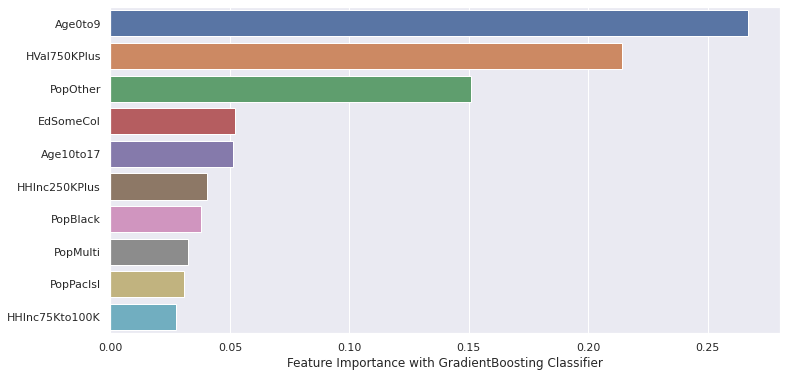

In [259]:
df_feature_importance = pd.DataFrame(gbc.feature_importances_, 
                                     index=st_dm_cols, 
                                     columns=['feature importance']).sort_values('feature importance', 
                                                                                 ascending=False).head(10)

ax = sns.barplot(x='feature importance', y=df_feature_importance.index, data=df_feature_importance)
ax.set_xlabel('Feature Importance with GradientBoosting Classifier')
plt.savefig('images/gbc_features.png', dpi=300, bbox_inches='tight')
plt.show()

### Predict new store format

In [260]:
transformed_data = column_transformer.transform(new_st)

def predict_new_store_segment(model, new_store_data=new_st, transformered_data=transformed_data):
    pred = model.predict(transformed_data)
    temp_df = new_store_data.assign(Segment = pred)
    
    return temp_df

In [261]:
# Predict Segment for New Store
segment_result_gb = predict_new_store_segment(gbc)

segment_result_gb[['Store', 'Segment']].reset_index(drop=True)

,Store,Segment
0,S0086,2
1,S0087,1
2,S0088,2
3,S0089,1
4,S0090,1
5,S0091,0
6,S0092,1
7,S0093,0
8,S0094,1
9,S0095,1


# Task 3

# Task 3: Forecasting

Fresh produce has a short life span, and due to increasing costs, the company wants to have an accurate monthly sales forecast.

You’ve been asked to prepare a monthly forecast for produce sales for the full year of 2016 for both existing and new stores.

Note: Use a 6 month holdout sample for the TS Compare tool (this is because we do not have that much data so using a 12 month holdout would remove too much of the data)

# Task 3 Submission

- What type of ETS or ARIMA model did you use for each forecast? Use ETS(a,m,n) or ARIMA(ar, i, ma) notation. How did you come to that decision?

 - Please provide a table of your forecasts for existing and new stores. Also, provide visualization of your forecasts that includes historical data, existing stores forecasts, and new stores forecasts

### Aggregate sales data by month and year for forcasting

**Step 1**: To forecast produce sales for existing stores you should aggregate produce sales across all stores by month and create a forecast.

In [262]:
# Filtering variables
columns_store_segment = ['Store', 'Segment']
# existing stores
existing_store_segment = sales_per_2015[columns_store_segment]
# new stores
new_store_segement = segment_result_gb[columns_store_segment]
# Merge stores sales data with existing store segment
stores_sales_segment = st_data.merge(existing_store_segment, on='Store')

In [263]:
# the sum of produce data in each year and month
produce_sales = stores_sales_segment.groupby(['Year', 'Month'], as_index=False)['Produce'].agg({'Monthly Sales':'sum'})
# Then create a datetime from month and year
date_time = produce_sales['Year'].astype(str)+ '-' + produce_sales['Month'].astype(str)
# convert to datetime format and assign to new column
produce_sales['Date'] = pd.to_datetime(date_time)
# set the Date column to index column
existing_sales = produce_sales.set_index('Date')['Monthly Sales']
# Monthly sales of produce
existing_sales.index.freq ='MS'
existing_sales.head()

Date
2012-03-01    25151525.84
2012-04-01    24406048.39
2012-05-01    28249539.01
2012-06-01    28691364.32
2012-07-01    28535707.45
Freq: MS, Name: Monthly Sales, dtype: float64

**Step 2:** To forecast produce sales for new stores:

   - Forecast produce sales (not total sales) for the average store (rather than the aggregate) for each segment.
   - Multiply the average store produce sales forecast by the number of new stores in that segment.
   
   - For example, if the forecasted average store produce sales for segment 1 for March is 10,000, and there are 4 new stores in segment 1, the forecast for the new stores in segment 1 would be 40,000.
    
   - Sum the new stores produce sales forecasts for each of the segments to get the forecast for all new stores.


### Aggregate monlthly produce sales for new store forecast

In [264]:
# aggregate and sum monlthly sales for each segment
monthly_sales = stores_sales_segment.groupby(['Store', 'Year', 'Month', 'Segment'], as_index=False)['Produce'].agg(
    {'Monthly Sales':'sum'})
# aggregate and find average sales
avg_monthly_sales = monthly_sales.groupby(['Year', 'Month', 'Segment'], as_index=False)['Monthly Sales'].agg(
    {'Avg Monthly Sales':'mean'})

# convet the year and month to datetimeindex
avg_monthly_sales['Year'].astype(str) +'-' + avg_monthly_sales['Month'].astype(str)
avg_monthly_sales['Date'] = pd.to_datetime(avg_monthly_sales['Year'].astype(str) +'-' + avg_monthly_sales['Month'].astype(str))
avg_monthly_sales = avg_monthly_sales.set_index('Date', drop=True)

# Plot TS Monthly Sales for  Existing Stores

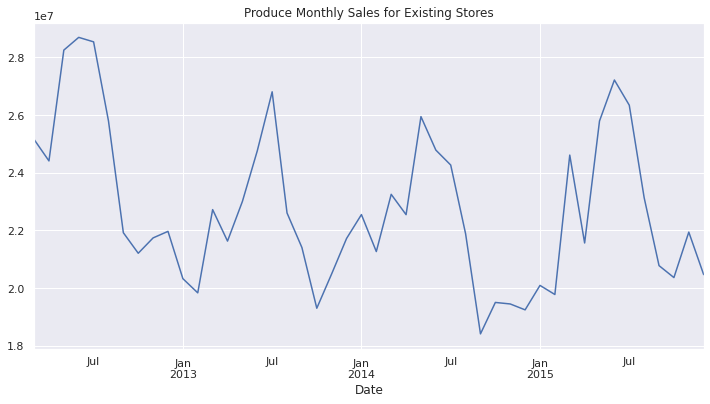

In [265]:
# Existing store
# plot TS data
existing_sales.plot(y='Monthly Sales', title="Produce Monthly Sales for Existing Stores", label='Existing Stores')
plt.show()

# Plot the Average Monthly Sales for each Segment

In [228]:
sns.set_theme(style="darkgrid")

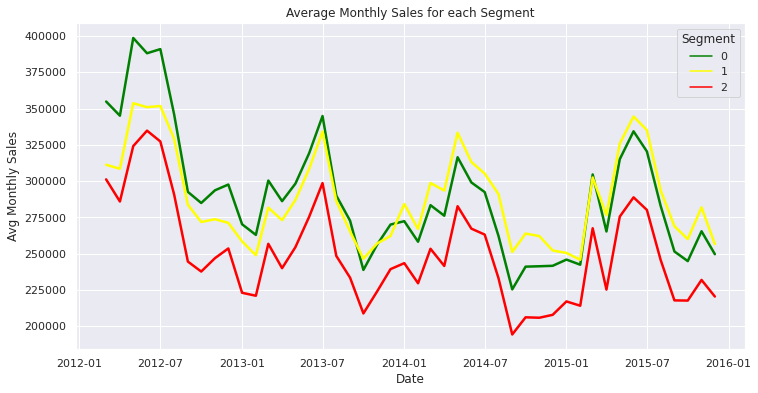

In [229]:
# Plot the Average Monthly Sales for each Segment
sns.lineplot(x="Date", y="Avg Monthly Sales",
             hue="Segment",
              data=avg_monthly_sales, palette=['green', 'yellow','red'], linewidth=2.5)
plt.title('Average Monthly Sales for each Segment')
plt.show()

# Determing the seasonal, trend, and error components

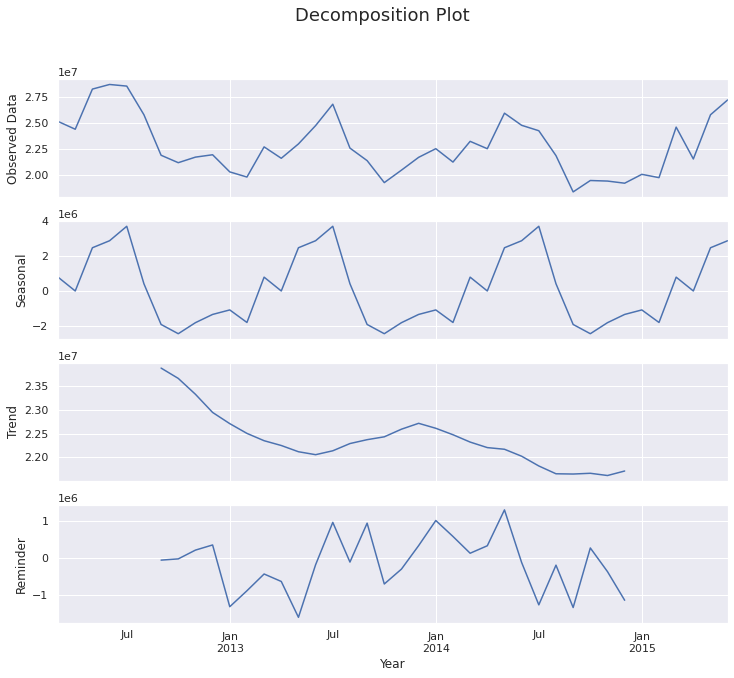

In [271]:
res = seasonal_decompose(train , model='additive', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Year")
plt.suptitle('Decomposition Plot',fontsize = 18)
plt.savefig('images/dec.png', dpi=300, bbox_inches='tight')

### Create train and test dataset from existing stores sales data

In [273]:
# Time Series Train Test Data
def time_series_train_test_split(df, size=6):
    test = df.iloc[-size:]
    temp = df.index.isin(test.index)
    train = df[~temp]
    
    return train, test

# Comparison of ARIMA and  ETS model using statsmodel

In [274]:
# time series train test split
train, test = time_series_train_test_split(existing_sales)

 # ETS Model using StasModels

In [280]:
# Train ETS model and forecast the next 12 months
# ETS(A,M,M)
ets_model = ETSModel(train, error='mul', trend=None, damped_trend=False, seasonal='mul', seasonal_periods=12)
ets_model_fit = ets_model.fit(disp=0)
# Forecast 2016 data
ets_forecast_result = ets_model_fit.forecast(6).round(2)

# ARIMA using StatsModels

In [283]:
# fit model
model = ARIMA(train, order=(0,1,1), trend=None)
arima_fit = model.fit()
# Forecast 2016 sales
arima_forecast_result = arima_fit.forecast(6).round(2)

# Model comparison Plot

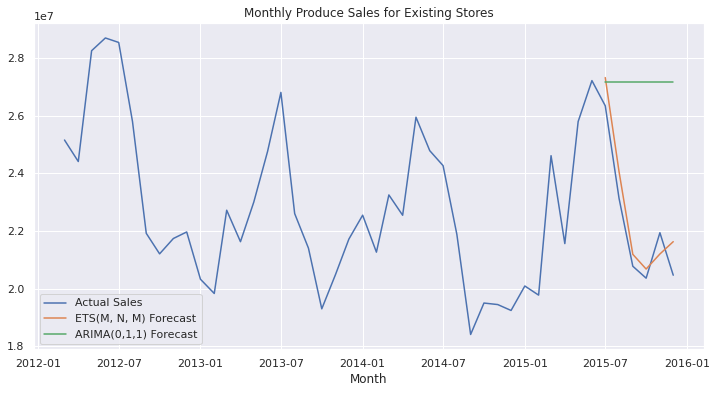

In [293]:
# Plot Models Holdout Forecast
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
# Plot Actual Sales
axs.plot(existing_sales, label='Actual Sales')
# Plot ETS forecast Sales
axs.plot(ets_forecast_result, label='ETS(M, N, M) Forecast')
# Plot ARIMA forecast Sales
axs.plot(arima_forecast_result, label='ARIMA(0,1,1) Forecast')
# add title and legend
axs.set_title('Monthly Produce Sales for Existing Stores')
axs.set_xlabel('Month')
axs.legend()

In [295]:
# Forecast 2016 Sales for Existing Stores
# Train the model with all data
existing_stores_forecast = ETSModel(existing_sales, error='mul', trend=None, damped_trend=False, seasonal='mul', seasonal_periods=12).fit().forecast(12).round()

In [297]:
new_stores_segment_0 = avg_monthly_sales.query('Segment==0')['Avg Monthly Sales']
new_stores_segment_0.index.freq='MS'

new_stores_segment_1 = avg_monthly_sales.query('Segment==1')['Avg Monthly Sales']
new_stores_segment_1.index.freq='MS'
new_stores_segment_2 = avg_monthly_sales.query('Segment==2')['Avg Monthly Sales']
new_stores_segment_2.index.freq='MS'

In [298]:
new_stores_segment_0.head()

Date
2012-03-01    354869.679500
2012-04-01    345094.158500
2012-05-01    398660.234500
2012-06-01    388123.358571
2012-07-01    390981.756667
Freq: MS, Name: Avg Monthly Sales, dtype: float64

In [299]:
# Forecast 2016 new store sales for each segments

forecast_segment_0 = ARIMA(new_stores_segment_0, order=(0,0,2), trend='ct').fit().forecast(12).round()
forecast_segment_1 = ARIMA(new_stores_segment_1, order=(0,0,2), trend='ct').fit().forecast(12).round()
forecast_segment_2 = ARIMA(new_stores_segment_2, order=(0,0,2), trend='ct').fit().forecast(12).round()


In [300]:
# Concat all segment forecast results
forecast_new_stores_segment = pd.concat([forecast_segment_0, forecast_segment_1, forecast_segment_2], axis=1)
forecast_new_stores_segment.columns = ['Segment_0', 'Segment_1', 'Segment_2']
# Count the segment in best cluster selected
best_cluster = segment_result_gb
segment_counts = best_cluster['Segment'].value_counts()
# add total sales per month
forecast_new_stores_segment = forecast_new_stores_segment.assign(Monthly_Sales = lambda x: x.Segment_0*segment_counts[0]+x.Segment_1*segment_counts[1]+x.Segment_2*segment_counts[2])
forecast_new_stores_segment.head()

,Segment_0,Segment_1,Segment_2,Monthly_Sales
2016-01-01,252780.0,267318.0,221322.0,2552112.0
2016-02-01,241642.0,260514.0,215361.0,2477090.0
2016-03-01,244790.0,273820.0,219119.0,2570738.0
2016-04-01,243021.0,273242.0,217906.0,2561306.0
2016-05-01,241251.0,272663.0,216693.0,2551866.0


In [301]:
# combine forecasted data
forecasted_result = pd.concat([existing_stores_forecast, forecast_new_stores_segment['Monthly_Sales']], axis=1)
forecasted_result.columns = ['New Stores', 'Existing Stores']
forecasted_result.index = forecasted_result.index.to_period('M')
# total mothly forecast sales
forecasted_result = forecasted_result.assign(Total_Stores_Forecast = lambda x: x['New Stores'] + x['Existing Stores'])

In [302]:
forecasted_result[['New Stores', 'Existing Stores']]

,New Stores,Existing Stores
2016-01,21129077.0,2552112.0
2016-02,20408753.0,2477090.0
2016-03,23638763.0,2570738.0
2016-04,22375530.0,2561306.0
2016-05,25576825.0,2551866.0
2016-06,26222939.0,2542430.0
2016-07,26426500.0,2532990.0
2016-08,23258223.0,2523558.0
2016-09,20592937.0,2514122.0
2016-10,20117865.0,2504682.0


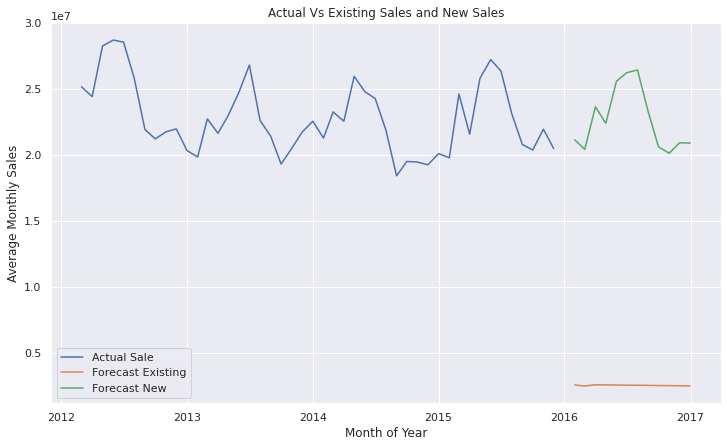

In [362]:
# Plot Models 2016 Forecast
fig, axs = plt.subplots(1, 1, figsize=(12, 7))
axs.plot(existing_sales, label='Actual Sale')
axs.plot(forecasted_result['Existing Stores'], label='Forecast Existing')
axs.plot(forecasted_result['New Stores'], label='Forecast New')
axs.set_title('Actual Vs Existing Sales and New Sales')
axs.set_xlabel('Month of Year')
axs.set_ylabel('Average Monthly Sales')
axs.legend()